In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
from bayes_opt import BayesianOptimization
sns.set()
from pprint import pprint
import json
import math
import fxcmpy
from sklearn import svm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import preprocessing
from IPython import get_ipython
ipy = get_ipython()
if ipy is not None:
    ipy.run_line_magic('matplotlib', 'inline')

In [2]:
def get_state(data, t, n):
    d = t - n + 1
    block = data[d : t + 1] if d >= 0 else -d * [data[0]] + data[0 : t + 1]
    res = []
    for i in range(n - 1):
        res.append(block[i + 1] - block[i])
    return np.array([res])

In [3]:
TOKEN ='8ea6466c9b90a9716bd26056a699639309f25fc4' #copy and paste access token from FXCM
con = fxcmpy.fxcmpy(access_token=TOKEN, log_level='error')
con.is_connected()

True

In [4]:
# print('Account ID')
# Account = con.get_account_ids()

In [5]:
# print('Open Orders')
# order_ids =con.get_order_ids()
# print(order_ids)

In [6]:
# print('Choose Instrument to trade')

In [7]:
# instruments = con.get_instruments()
# print(instruments)

In [8]:
# Ticker = str(input())

In [9]:
# Bars = str(input('Choose Bar Period' '\nMust be m1, m5, m15, m30, H1, H2, H3, H4, H6, H8, D1, W1 or M1: '))

In [10]:
# Loop this update of candles every X minutes once the best optimisation has run
# Maybe save this this data to a table and append with each new update
# Maybe fork process to split Parent and Child process

In [11]:
try:
    df = con.get_candles('XAU/USD', period='m15', number=500)
except ValueError:
        print('Please Check Instrument or Period')

In [12]:
close = df.bidclose.values.tolist()
window_size = 30
skip = 5
l = len(close) - 1

In [13]:
class Deep_Evolution_Strategy:

    inputs = None

    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / np.std(rewards)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    / (self.population_size * self.sigma)
                    * np.dot(A.T, rewards).T
                )
            if (i + 1) % print_every == 0:
                print(
                    'iter %d. reward: %f'
                    % (i + 1, self.reward_function(self.weights))
                )
        print('time taken to train:', time.time() - lasttime, 'seconds')


class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(layer_size, 1),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        buy = np.dot(feed, self.weights[2])
        return decision, buy

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [14]:
class Agent:
    def __init__(
        self,
        population_size,
        sigma,
        learning_rate,
        model,
        money,
        max_buy,
        max_sell,
        skip,
        window_size,
    ):
        self.window_size = window_size
        self.skip = skip
        self.POPULATION_SIZE = population_size
        self.SIGMA = sigma
        self.LEARNING_RATE = learning_rate
        self.model = model
        self.initial_money = money
        self.max_buy = max_buy
        self.max_sell = max_sell
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )

    def act(self, sequence):
        decision, buy = self.model.predict(np.array(sequence))
        return np.argmax(decision[0]), int(buy[0])

    def get_reward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        self.model.weights = weights
        state = get_state(close, 0, self.window_size + 1)
        inventory = []
        quantity = 0
        for t in range(0, l, self.skip):
            action, buy = self.act(state)
            next_state = get_state(close, t + 1, self.window_size + 1)
            if action == 1 and initial_money >= close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
            elif action == 2 and len(inventory) > 0:
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell

            state = next_state
        return ((initial_money - starting_money) / starting_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def buy(self):
        initial_money = self.initial_money
        state = get_state(close, 0, self.window_size + 1)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        quantity = 0
        profit = 0
        loss = 0
        for t in range(0, l, self.skip):
            action, buy = self.act(state)
            next_state = get_state(close, t + 1, self.window_size + 1)
            if action == 1 and initial_money >= close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
                states_buy.append(t)
                print(
                    'day %d: buy %d units at price %f, total balance %f'
                    % (t, buy_units, total_buy, initial_money)
                )
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                if sell_units < 1:
                    continue
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell
                states_sell.append(t)
                try:
                    invest = ((total_sell - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (t, sell_units, total_sell, invest, initial_money)
                )
                if invest > 0:
                    profit += 1
                else:
                    loss += 1
            state = next_state

        invest = ((initial_money - starting_money) / starting_money) * 100
        ratio = (profit / (loss + profit)) * 100
        print(
            '\ntotal gained %f, total investment %f %%'
            % (initial_money - starting_money, invest)
        )
        print(
            'total wins %d , total losses %d, accuracy ratio: %f'
            % (profit , loss , ratio)
            )
        print('left in inventory: %d' % (len(inventory)))
        print(inventory)
        print('\nPredicted Buy/Sell for ' +str(len(close))+ ' ROI: ' + str(int(invest))+'%')
        plt.figure(figsize = (20, 10))
        plt.plot(close, label = 'true close', c = 'g')
        plt.plot(
            close, 'X', label = 'predict buy', markevery = states_buy, c = 'b'
        )
        plt.plot(
            close, 'o', label = 'predict sell', markevery = states_sell, c = 'r'
        )
        plt.legend()
        plt.show()

In [15]:
def best_agent(
    window_size, skip, population_size, sigma, learning_rate, size_network
):
    model = Model(window_size, size_network, 3)
    agent = Agent(
        population_size,
        sigma,
        learning_rate,
        model,
        1600,
        200,
        200,
        skip,
        window_size,
    )
    try:
        agent.fit(10, 1000)
        return agent.es.reward_function(agent.es.weights)
    except:
        return 0

In [16]:
def find_best_agent(
    window_size, skip, population_size, sigma, learning_rate, size_network
):
    global accbest
    param = {
        'window_size': int(np.around(window_size)),
        'skip': int(np.around(skip)),
        'population_size': int(np.around(population_size)),
        'sigma': max(min(sigma, 1), 0.0001),
        'learning_rate': max(min(learning_rate, 0.5), 0.000001),
        'size_network': int(np.around(size_network)),
    }
    print('\nSearch parameters %s' % (param))
    investment = best_agent(**param)
    print('stop after 100 iteration with investment %f' % (investment))
    if investment > accbest:
        costbest = investment
    return investment

In [17]:
accbest = 0.0
NN_BAYESIAN = BayesianOptimization(
    find_best_agent,
    {
        'window_size': (2, 50),# Default: 2,50
        'skip': (1, 15), # Default: 1, 15
        'population_size': (1, 50),# Default: 1, 50
        'sigma': (0.01, 0.99),
        'learning_rate': (0.000001, 0.29),# Default: 0.000001 , 0.49
        'size_network': (1, 100),# Default: 10, 1000
    },
)
NN_BAYESIAN.maximize(init_points =50, n_iter = 80, acq = 'ei', xi = 0.0) # Default: init_points=30 n_iter=50

Initialization
----------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   learning_rate |   population_size |     sigma |   size_network |      skip |   window_size | 

Search parameters {'window_size': 28, 'skip': 13, 'population_size': 13, 'sigma': 0.44836110465744217, 'learning_rate': 0.19512438082365463, 'size_network': 17}
time taken to train: 0.2473466396331787 seconds
stop after 100 iteration with investment 13.596875
    1 | 00m00s |   13.59687 |          0.1951 |           12.8839 |    0.4484 |        16.5254 |   12.7515 |       27.7115 | 

Search parameters {'window_size': 36, 'skip': 9, 'population_size': 45, 'sigma': 0.3331121191275869, 'learning_rate': 0.24240433328963107, 'size_network': 9}
time taken to train: 1.1025333404541016 seconds
stop after 100 iteration with investment 15.590625
    2 | 00m01s |   15.59063 |          0.2424 |           44.8516 |    0.3331 |         9

time taken to train: 1.7899563312530518 seconds
stop after 100 iteration with investment 2.000000
   21 | 00m01s |    2.00000 |          0.1619 |           46.3846 |    0.6703 |        95.3537 |    4.8227 |       25.3959 | 

Search parameters {'window_size': 28, 'skip': 6, 'population_size': 6, 'sigma': 0.572930856562598, 'learning_rate': 0.08841158415098038, 'size_network': 4}
time taken to train: 0.20048093795776367 seconds
stop after 100 iteration with investment 0.095000
   22 | 00m00s |    0.09500 |          0.0884 |            5.9138 |    0.5729 |         4.4441 |    6.2111 |       28.3877 | 

Search parameters {'window_size': 17, 'skip': 13, 'population_size': 12, 'sigma': 0.7145884862942842, 'learning_rate': 0.2854175352022216, 'size_network': 15}
time taken to train: 0.16244196891784668 seconds
stop after 100 iteration with investment 0.649375
   23 | 00m00s |    0.64937 |          0.2854 |           11.6068 |    0.7146 |        15.2796 |   13.4780 |       16.9237 | 

Search p

C:\Users\Bl4ckP3n9u1n\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


stop after 100 iteration with investment 0.000000
   35 | 00m00s |    0.00000 |          0.2672 |           38.8302 |    0.0122 |        96.0165 |   13.3329 |       16.0024 | 

Search parameters {'window_size': 39, 'skip': 3, 'population_size': 42, 'sigma': 0.27991137392961307, 'learning_rate': 0.24050581752521166, 'size_network': 62}
time taken to train: 2.8377397060394287 seconds
stop after 100 iteration with investment -24.106875
   36 | 00m02s |  -24.10687 |          0.2405 |           42.3776 |    0.2799 |        61.8098 |    2.8375 |       39.3939 | 

Search parameters {'window_size': 31, 'skip': 6, 'population_size': 47, 'sigma': 0.5064283533028134, 'learning_rate': 0.05417039696023576, 'size_network': 13}
time taken to train: 1.4789927005767822 seconds
stop after 100 iteration with investment 3.486250
   37 | 00m01s |    3.48625 |          0.0542 |           46.7402 |    0.5064 |        12.9130 |    6.4163 |       31.0700 | 

Search parameters {'window_size': 8, 'skip': 8, 'pop

time taken to train: 0.9866588115692139 seconds
stop after 100 iteration with investment 1.571875
   56 | 00m03s |    1.57188 |          0.2626 |           39.5211 |    0.8517 |        84.9664 |    5.7107 |        6.3380 | 

Search parameters {'window_size': 5, 'skip': 7, 'population_size': 46, 'sigma': 0.5603276193077529, 'learning_rate': 0.06733871113245397, 'size_network': 61}
time taken to train: 0.9680349826812744 seconds
stop after 100 iteration with investment 0.106875
   57 | 00m02s |    0.10688 |          0.0673 |           46.1810 |    0.5603 |        61.3009 |    7.1018 |        4.5798 | 

Search parameters {'window_size': 43, 'skip': 11, 'population_size': 6, 'sigma': 0.5602953020729698, 'learning_rate': 0.1379879578422017, 'size_network': 82}
time taken to train: 0.13500165939331055 seconds
stop after 100 iteration with investment 24.478125
   58 | 00m02s |   24.47813 |          0.1380 |            6.3752 |    0.5603 |        81.5627 |   10.9059 |       42.8526 | 

Search 


Search parameters {'window_size': 16, 'skip': 3, 'population_size': 49, 'sigma': 0.15347485373856015, 'learning_rate': 0.23039927370071991, 'size_network': 58}
time taken to train: 2.3861677646636963 seconds
stop after 100 iteration with investment 60.356875
   78 | 00m05s |   60.35687 |          0.2304 |           48.5145 |    0.1535 |        58.2257 |    3.3561 |       16.1042 | 

Search parameters {'window_size': 2, 'skip': 5, 'population_size': 31, 'sigma': 0.6816185880065773, 'learning_rate': 0.12871353570235092, 'size_network': 67}
time taken to train: 0.6011910438537598 seconds
stop after 100 iteration with investment 0.000000
   79 | 00m03s |    0.00000 |          0.1287 |           31.2269 |    0.6816 |        66.8154 |    5.3303 |        2.4631 | 

Search parameters {'window_size': 37, 'skip': 5, 'population_size': 5, 'sigma': 0.1105081868658164, 'learning_rate': 0.17641268079600575, 'size_network': 10}
time taken to train: 0.16929364204406738 seconds
stop after 100 iteratio

C:\Users\Bl4ckP3n9u1n\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide



Search parameters {'window_size': 36, 'skip': 14, 'population_size': 18, 'sigma': 0.5505959964958911, 'learning_rate': 0.15958352656830807, 'size_network': 38}
time taken to train: 0.30425286293029785 seconds
stop after 100 iteration with investment -75.641875
   94 | 00m03s |  -75.64187 |          0.1596 |           17.5225 |    0.5506 |        38.4076 |   14.2443 |       35.5581 | 

Search parameters {'window_size': 29, 'skip': 12, 'population_size': 32, 'sigma': 0.5868244505281554, 'learning_rate': 0.13556871195233236, 'size_network': 29}
time taken to train: 0.5997536182403564 seconds
stop after 100 iteration with investment 0.421250
   95 | 00m03s |    0.42125 |          0.1356 |           32.2970 |    0.5868 |        29.4731 |   11.9610 |       29.2414 | 

Search parameters {'window_size': 8, 'skip': 3, 'population_size': 41, 'sigma': 0.20709464808599531, 'learning_rate': 0.13619188694694997, 'size_network': 99}
time taken to train: 2.1499433517456055 seconds
stop after 100 iter

C:\Users\Bl4ckP3n9u1n\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide



Search parameters {'window_size': 29, 'skip': 9, 'population_size': 45, 'sigma': 0.34217467909358124, 'learning_rate': 0.04984921930535268, 'size_network': 5}
time taken to train: 1.1249926090240479 seconds
stop after 100 iteration with investment 0.360625
  102 | 00m04s |    0.36062 |          0.0498 |           44.8040 |    0.3422 |         4.7430 |    8.9906 |       29.2741 | 

Search parameters {'window_size': 39, 'skip': 10, 'population_size': 20, 'sigma': 0.7111877708099118, 'learning_rate': 0.018496494509498893, 'size_network': 25}
time taken to train: 0.5099306106567383 seconds
stop after 100 iteration with investment -403.444375
  103 | 00m04s | -403.44437 |          0.0185 |           20.3729 |    0.7112 |        25.3185 |   10.3589 |       39.3644 | 

Search parameters {'window_size': 9, 'skip': 7, 'population_size': 27, 'sigma': 0.3815572424974729, 'learning_rate': 0.0914613499738712, 'size_network': 98}
time taken to train: 0.5999429225921631 seconds
stop after 100 iterat

C:\Users\Bl4ckP3n9u1n\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide



Search parameters {'window_size': 21, 'skip': 13, 'population_size': 38, 'sigma': 0.5714714718331506, 'learning_rate': 0.05295002368223643, 'size_network': 79}
time taken to train: 0.7392716407775879 seconds
stop after 100 iteration with investment 0.331250
  106 | 00m04s |    0.33125 |          0.0530 |           37.6658 |    0.5715 |        79.1471 |   12.5682 |       21.4909 | 

Search parameters {'window_size': 23, 'skip': 9, 'population_size': 25, 'sigma': 0.4987502739035665, 'learning_rate': 0.04272999613270354, 'size_network': 50}
time taken to train: 0.5162367820739746 seconds
stop after 100 iteration with investment -79.690625
  107 | 00m03s |  -79.69062 |          0.0427 |           25.0678 |    0.4988 |        50.3786 |    9.2000 |       22.6857 | 

Search parameters {'window_size': 28, 'skip': 7, 'population_size': 49, 'sigma': 0.19867426637388858, 'learning_rate': 0.19389246102507107, 'size_network': 48}
time taken to train: 1.060861349105835 seconds
stop after 100 iterat

time taken to train: 0.4407975673675537 seconds
stop after 100 iteration with investment 21.891250
  127 | 00m03s |   21.89125 |          0.1949 |           20.2299 |    0.4510 |        92.7640 |    7.0504 |       13.9394 | 

Search parameters {'window_size': 12, 'skip': 11, 'population_size': 17, 'sigma': 0.43449663109329467, 'learning_rate': 0.0044873375884317964, 'size_network': 90}
time taken to train: 0.28097081184387207 seconds
stop after 100 iteration with investment -887.395000
  128 | 00m03s | -887.39500 |          0.0045 |           17.1812 |    0.4345 |        89.5590 |   10.6678 |       11.8641 | 

Search parameters {'window_size': 8, 'skip': 7, 'population_size': 9, 'sigma': 0.3659760105561077, 'learning_rate': 0.07716438190455291, 'size_network': 39}
time taken to train: 0.3974878787994385 seconds
stop after 100 iteration with investment 0.072500
  129 | 00m04s |    0.07250 |          0.0772 |            9.1828 |    0.3660 |        39.2622 |    7.2412 |        7.8543 | 



In [18]:
print('Best AGENT accuracy value: %f' % NN_BAYESIAN.res['max']['max_val'])
print('Best AGENT parameters: ', NN_BAYESIAN.res['max']['max_params'])

Best AGENT accuracy value: 168.876250
Best AGENT parameters:  {'window_size': 43.56460370846337, 'skip': 7.607106320757929, 'population_size': 28.415319407241217, 'sigma': 0.1718968435044273, 'learning_rate': 0.17117329185844352, 'size_network': 81.78818433104155}


In [19]:
bayes_res = str(NN_BAYESIAN.res['max']['max_params'])
bayes_res = json.loads(bayes_res.replace("'", "\""))
bayes_res['window_size'] = int(round(bayes_res['window_size']))
bayes_res['skip'] = int(round(bayes_res['skip']))
bayes_res['population_size'] = int(round(bayes_res['population_size']))
bayes_res['size_network'] = int(round(bayes_res['size_network']))
pprint(bayes_res)

{'learning_rate': 0.17117329185844352,
 'population_size': 28,
 'sigma': 0.1718968435044273,
 'size_network': 82,
 'skip': 8,
 'window_size': 44}


C:\Users\Bl4ckP3n9u1n\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


time taken to train: 7.597066640853882 seconds
day 32: buy 200 units at price 256592.000000, total balance -254992.000000
day 40, sell 200 units at price 256732.000000, investment 0.054561 %, total balance 1740.000000,
day 72: buy 200 units at price 256244.000000, total balance -254504.000000
day 128, sell 200 units at price 257430.000000, investment 0.462840 %, total balance 2926.000000,
day 184: buy 1 units at price 1284.860000, total balance 1641.140000
day 264: buy 200 units at price 255592.000000, total balance -253950.860000
day 272, sell 200 units at price 255640.000000, investment 19796.331118 %, total balance 1689.140000,
day 280: buy 200 units at price 255986.000000, total balance -254296.860000
day 320, sell 200 units at price 256996.000000, investment 0.549313 %, total balance 2699.140000,
day 328, sell 1 units at price 1282.640000, investment -99.498941 %, total balance 3981.780000,
day 384: buy 200 units at price 255918.000000, total balance -251936.220000
day 480, sell 2

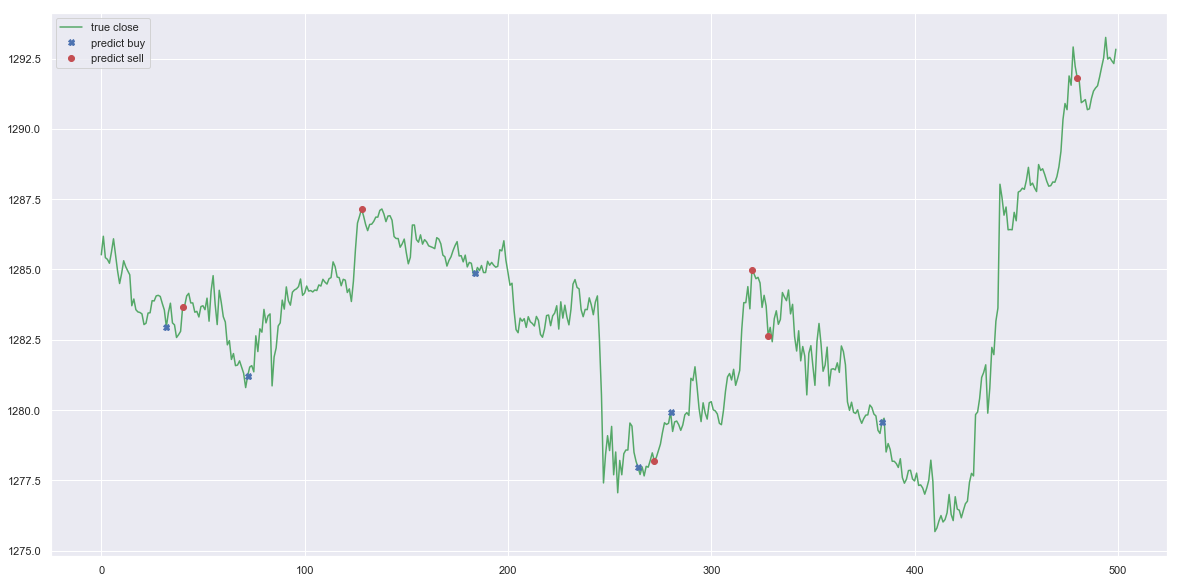

In [20]:
# 1600 = Funds or Margin, Buy / Sell = 200 , 200
model = Model(bayes_res['window_size'], bayes_res['size_network'], 3)
agent = Agent(
    bayes_res['population_size'], bayes_res['sigma'], bayes_res['learning_rate'], model, 1600, 200, 200, bayes_res['skip'], bayes_res['window_size']
)
agent.fit(bayes_res['size_network'], 100)
agent.buy()

In [21]:
forecast_col = 'bidclose'
df.fillna(-99999, inplace=True)

forecast_out = int(math.ceil(0.01*len(df)))
print(forecast_out)

df['label'] = df[forecast_col].shift(-forecast_out)
df.dropna(inplace=True) # may not need this

x = np.array(df.drop(['label'],1))
y = np.array(df['label'])
X = preprocessing.scale(X)
x = X[:-forecast_out]
X_lately = X [-forecast_out:]

df.dropna(inplace=True)
y = np.array(df['label'])
y = np.array(df['label'])

X_train, X_test, y_train, y_test, = train_test_split(X, y, test_size=0.2) # 20% of df to train

clf=svm.SVR() # This can be changed if the model is not using this E.g. LinearRegression
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test) # https://scikit-learn.org/stable/modules/cross_validation.html
forecast_set = clf.predict(X_lately)
print('forecast_set, accuracy, forecast_out')
df.['Forecast'] = np.nan

last_date = df.iloc[-1].name
last_unix = last.date.timestamp()
one_day = 86000 # Seconds in a day, this is based on daily data
next_day = last_unix + one_day

SyntaxError: invalid syntax (<ipython-input-21-8eb48d287fa7>, line 27)